## Text Classification Project: Consumer Complaints Dataset


## Project Overview
This project involves the classification of consumer complaints into predefined categories using various Natural Language Processing (NLP) techniques and machine learning models. The goal is to develop a robust text classification model that can accurately categorize complaints into one of the five categories: **credit_card**, **retail_banking**, **credit_reporting**, **mortgages_and_loans**, and **debt_collection**.

## Data
The dataset for this project is taken from Kaggle: <br>
https://www.kaggle.com/datasets/shashwatwork/consume-complaints-dataset-fo-nlp/code?datasetId=1363681&sortBy=voteCount

The dataset contains a large number of consumer complaints, along with the corresponding categories.

### Categories
The complaints are classified into the following categories:
- **Credit Card**
- **Retail Banking**
- **Credit Reporting**
- **Mortgages and Loans**
- **Debt Collection**

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
import re

import spacy

try:
    # Try loading the model to check if it's installed
    nlp = spacy.load("en_core_web_lg")
    print("Model is already installed.")
except OSError:
    # If the model isn't installed, download it
    !python -m spacy download en_core_web_lg
    nlp = spacy.load("en_core_web_lg")
    print("Model installed and loaded.")

from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import MinMaxScaler

import tensorflow as tf
from wordcloud import WordCloud

from typing import Dict
from sklearn.base import BaseEstimator
from sklearn.model_selection import cross_val_score
from time import time
from sklearn.metrics import accuracy_score, confusion_matrix

from sklearn.ensemble import RandomForestClassifier, ExtraTreesClassifier, GradientBoostingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.naive_bayes import MultinomialNB
from sklearn.tree import DecisionTreeClassifier
# import xgboost as xgb

import warnings
warnings.filterwarnings('ignore')

Model is already installed.


2024-08-18 05:15:22.886562: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-08-18 05:15:22.886679: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-08-18 05:15:23.038151: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


In [2]:
# Reading the CSV file into a DataFrame
# The file contains complaints data

data = pd.read_csv('/kaggle/input/consume-complaints-dataset-fo-nlp/complaints_processed.csv')

In [3]:
# Displaying the first 5 rows of the data
data.head(5)

,Unnamed: 0,product,narrative
0,0,credit_card,purchase order day shipping amount receive pro...
1,1,credit_card,forwarded message date tue subject please inve...
2,2,retail_banking,forwarded message cc sent friday pdt subject f...
3,3,credit_reporting,payment history missing credit report speciali...
4,4,credit_reporting,payment history missing credit report made mis...


In [4]:
# Selecting only the 'product' and 'narrative' columns
data = data[['product', 'narrative']]

# Displaying the first 5 rows of the modified dataset
data.head(5)

,product,narrative
0,credit_card,purchase order day shipping amount receive pro...
1,credit_card,forwarded message date tue subject please inve...
2,retail_banking,forwarded message cc sent friday pdt subject f...
3,credit_reporting,payment history missing credit report speciali...
4,credit_reporting,payment history missing credit report made mis...


In [5]:
# Creating a copy of the data
df = data.copy()

# Displaying the summary information of the DataFrame
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 162421 entries, 0 to 162420
Data columns (total 2 columns):
 #   Column     Non-Null Count   Dtype 
---  ------     --------------   ----- 
 0   product    162421 non-null  object
 1   narrative  162411 non-null  object
dtypes: object(2)
memory usage: 2.5+ MB


In [6]:
# Checking for missing values in the DataFrame
df.isna().sum()

product       0
narrative    10
dtype: int64

In [7]:
# Displaying rows where 'narrative' column has missing values
df[df['narrative'].isna()]

,product,narrative
1089,credit_reporting,NaN
3954,credit_reporting,NaN
3955,credit_reporting,NaN
29690,credit_reporting,NaN
139436,debt_collection,NaN
151052,debt_collection,NaN
154494,credit_reporting,NaN
156902,retail_banking,NaN
158538,credit_reporting,NaN
159503,credit_reporting,NaN


In [8]:
# Dropping rows with missing values and displaying updated information
df.dropna(axis=0, inplace=True)
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 162411 entries, 0 to 162420
Data columns (total 2 columns):
 #   Column     Non-Null Count   Dtype 
---  ------     --------------   ----- 
 0   product    162411 non-null  object
 1   narrative  162411 non-null  object
dtypes: object(2)
memory usage: 3.7+ MB


In [9]:
# Counting the number of duplicated rows in the DataFrame
df.duplicated().sum()

37735

In [10]:
# Displaying the first 10 duplicated rows in the DataFrame
df[df.duplicated()].head(10)

,product,narrative
32,credit_reporting,name last four s account number writing disput...
44,credit_reporting,open account acct opened balance account acct ...
69,credit_reporting,hello name trying reach several time get probl...
70,credit_reporting,hello name trying reach several time get probl...
112,credit_reporting,name trying make change credit report since sa...
121,credit_reporting,name trying fix incorrect information credit r...
170,credit_reporting,block except otherwise provided section consum...
172,credit_reporting,block except otherwise provided section consum...
173,credit_reporting,block except otherwise provided section consum...
174,credit_reporting,block except otherwise provided section consum...


In [11]:
# Drop duplicate rows, keeping the first occurrence and ignoring the index
df.drop_duplicates(keep='first', inplace=True, ignore_index=True)

# Displaying DataFrame info after removing duplicates
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 124676 entries, 0 to 124675
Data columns (total 2 columns):
 #   Column     Non-Null Count   Dtype 
---  ------     --------------   ----- 
 0   product    124676 non-null  object
 1   narrative  124676 non-null  object
dtypes: object(2)
memory usage: 1.9+ MB


In [12]:
df.head()

,product,narrative
0,credit_card,purchase order day shipping amount receive pro...
1,credit_card,forwarded message date tue subject please inve...
2,retail_banking,forwarded message cc sent friday pdt subject f...
3,credit_reporting,payment history missing credit report speciali...
4,credit_reporting,payment history missing credit report made mis...


In [13]:
# Count the number of empty strings in each column
empty_string_counts = df.apply(lambda x: (x == '').sum())
print(empty_string_counts)

product      0
narrative    0
dtype: int64


In [14]:
# Calculate the length of each text in the 'narrative' column and add it as a new column 'length'
df['length'] = df['narrative'].apply(lambda x: len(x))

# Display a random sample of 10 rows from the DataFrame
df.sample(10)

,product,narrative,length
109324,credit_reporting,may concern ton old debt collection credit fil...,365
93744,credit_reporting,remove fraud alert credit file transunon,40
26204,mortgages_and_loans,applied mortgage loan cornerstone home lending...,1796
93881,credit_reporting,report wrong address tx,23
23474,debt_collection,filing dispute regard incorrect item credit re...,201
88479,mortgages_and_loans,loan paid full dovenmuehle mortgage date recei...,297
13116,credit_card,due placed bed rest related lost job forced fa...,218
62746,credit_reporting,went get financing vehicle advance eager go bu...,703
4998,debt_collection,ar account resolution reporting account credit...,116
119099,credit_card,closed account without knowledge last payment ...,127


In [15]:
# Display rows where the length of 'narrative' text is less than 10 characters
short_texts_df = df[df['length'] < 10]
print(short_texts_df)

                    product  narrative  length
874        credit_reporting    account       7
1357        debt_collection  debt idea       9
7559         retail_banking    connect       7
7571         retail_banking   link pnc       8
7594         retail_banking  ca access       9
12314       debt_collection  debt paid       9
12320       debt_collection  debt owed       9
12321      credit_reporting  debt owed       9
12595      credit_reporting    inquire       7
12740        retail_banking  dismissed       9
12913      credit_reporting     belong       6
16201      credit_reporting        fdc       3
17469        retail_banking     friday       6
31414       debt_collection   owe debt       8
42765      credit_reporting       idea       4
77137      credit_reporting       need       4
77379      credit_reporting   response       8
77462      credit_reporting   inquires       8
77463      credit_reporting       item       4
77632      credit_reporting    financa       7
77729        

In [16]:
# Remove rows from the DataFrame where the length of the 'narrative' text is less than 10 characters
df = df[~(df['length'] < 10)]

# Display information about the DataFrame after removing short texts
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 124633 entries, 0 to 124672
Data columns (total 3 columns):
 #   Column     Non-Null Count   Dtype 
---  ------     --------------   ----- 
 0   product    124633 non-null  object
 1   narrative  124633 non-null  object
 2   length     124633 non-null  int64 
dtypes: int64(1), object(2)
memory usage: 3.8+ MB


In [17]:
# Get the count of each unique value in the 'product' column
df['product'].value_counts()

product
credit_reporting       56283
debt_collection        21106
mortgages_and_loans    18758
credit_card            15023
retail_banking         13463
Name: count, dtype: int64

In [18]:
# Create a copy of the original dataframe for manipulation
df_full = df.copy()

# Define the sample size and random state for reproducibility
sample_size = 10
rand_state = 2024

# Sample 10 rows from each product category
df1 = df[df['product'] == 'credit_reporting'].sample(n=sample_size, random_state=rand_state)
df2 = df[df['product'] == 'debt_collection'].sample(n=sample_size, random_state=rand_state)
df3 = df[df['product'] == 'mortgages_and_loans'].sample(n=sample_size, random_state=rand_state)
df4 = df[df['product'] == 'credit_card'].sample(n=sample_size, random_state=rand_state)
df5 = df[df['product'] == 'retail_banking'].sample(n=sample_size, random_state=rand_state)

# Concatenate the sampled data from each category into a single dataframe
df = pd.concat([df1, df2, df3, df4, df5], axis=0, ignore_index=True)

# Display the updated dataframe information
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50 entries, 0 to 49
Data columns (total 3 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   product    50 non-null     object
 1   narrative  50 non-null     object
 2   length     50 non-null     int64 
dtypes: int64(1), object(2)
memory usage: 1.3+ KB


In [19]:
# Display the count of samples for each product category
df['product'].value_counts()

product
credit_reporting       10
debt_collection        10
mortgages_and_loans    10
credit_card            10
retail_banking         10
Name: count, dtype: int64

In [20]:
# Precompile the regular expression for whitespace replacement
whitespace_re = re.compile(r'\s+')

def text_pre_process(text):
    """
    Preprocesses the input text by lowercasing, trimming whitespace,
    replacing multiple spaces with a single space, lemmatizing,
    and removing stop words, punctuation, and digits.
    """
    text = text.lower()  # Convert text to lowercase
    text = text.strip()  # Trim leading and trailing whitespace
    text = whitespace_re.sub(' ', text)  # Replace multiple spaces with a single space

    # Process text with SpaCy
    doc = nlp(text)

    # Extract lemmatized tokens, excluding stop words, punctuation, and digits
    tokens = [token.lemma_ for token in doc if not token.is_stop and not token.is_punct and not token.is_digit]

    # Join tokens into a single string
    return ' '.join(tokens)

In [21]:
# Apply text preprocessing to the DataFrame
df['text_pre_processed'] = df['narrative'].apply(text_pre_process)

# Display the DataFrame
df.head()

,product,narrative,length,text_pre_processed
0,credit_reporting,pmab llc saying owe medical hospital bill paid...,127,pmab llc say owe medical hospital bill pay gra...
1,credit_reporting,contacted experian correct information report ...,874,contact experian correct information report di...
2,credit_reporting,experian reporting day late partial account nu...,713,experian reporting day late partial account nu...
3,credit_reporting,name address account wrong request processed o...,1000,address account wrong request process online m...
4,credit_reporting,several unrecognizable credit inquires credit ...,180,unrecognizable credit inquire credit profile o...


In [22]:
# Calculate the length of preprocessed text
df['length_text_pre_processed'] = df['text_pre_processed'].apply(lambda x: len(x))

# Display the DataFrame
df.head()

,product,narrative,length,text_pre_processed,length_text_pre_processed
0,credit_reporting,pmab llc saying owe medical hospital bill paid...,127,pmab llc say owe medical hospital bill pay gra...,116
1,credit_reporting,contacted experian correct information report ...,874,contact experian correct information report di...,779
2,credit_reporting,experian reporting day late partial account nu...,713,experian reporting day late partial account nu...,616
3,credit_reporting,name address account wrong request processed o...,1000,address account wrong request process online m...,936
4,credit_reporting,several unrecognizable credit inquires credit ...,180,unrecognizable credit inquire credit profile o...,165


In [23]:
# Calculate descriptive statistics for the 'length_text_pre_processed' column
# This includes basic metrics like mean, standard deviation, and specific percentiles.
# Specifed percentiles to include in the output
# Transpose the result for better readability

df['length_text_pre_processed'].describe(percentiles=[0.05, 0.1, 0.25, 0.5, 0.75, 0.9, 0.95]).T

count      50.000000
mean      521.780000
std       409.454255
min        61.000000
5%         98.800000
10%       131.300000
25%       255.000000
50%       370.000000
75%       724.750000
90%      1007.100000
95%      1163.550000
max      1872.000000
Name: length_text_pre_processed, dtype: float64

In [24]:
# Filter the DataFrame to include only rows where the length of the preprocessed text is less than 10 characters
df[df['length_text_pre_processed'] < 10]

,product,narrative,length,text_pre_processed,length_text_pre_processed


In [25]:
def plot_wordcloud(df, label_name):
    """
    Plots a word cloud for the given label name from the DataFrame.

    Parameters:
    df (pandas.DataFrame): The input DataFrame containing 'narrative' and 'product' columns.
    label_name (str): The label name for which the word cloud is to be generated.
    """
    # Filter the DataFrame to include only rows where the 'product' column matches the label_name
    label_texts = df[df['product'] == label_name]['narrative']

    # Combine all the text for the specified label into a single string
    combined_text = " ".join(label_texts)

    # Generate the word cloud with a black border
    wordcloud = WordCloud(
        width=1600,
        height=800,
        background_color='white',
    ).generate(combined_text)

    # Plot the word cloud
    plt.figure(figsize=(10, 5))  # Set the figure size
    plt.imshow(wordcloud, interpolation='bilinear')  # Display the word cloud image
    plt.axis('off')  # Hide the axis
    plt.title(f'Word Cloud for {label_name}')  # Add a title to the plot
    plt.show()  # Show the plot

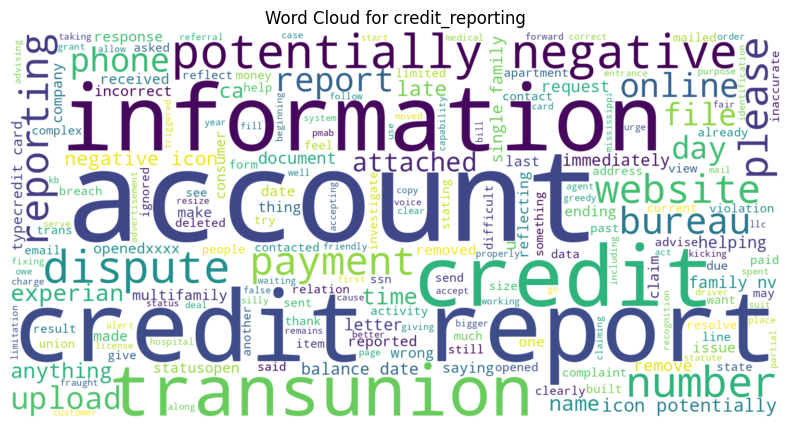

In [26]:
# Plot a word cloud for the first unique product label in the DataFrame
plot_wordcloud(df=df, label_name=df['product'].unique()[0])

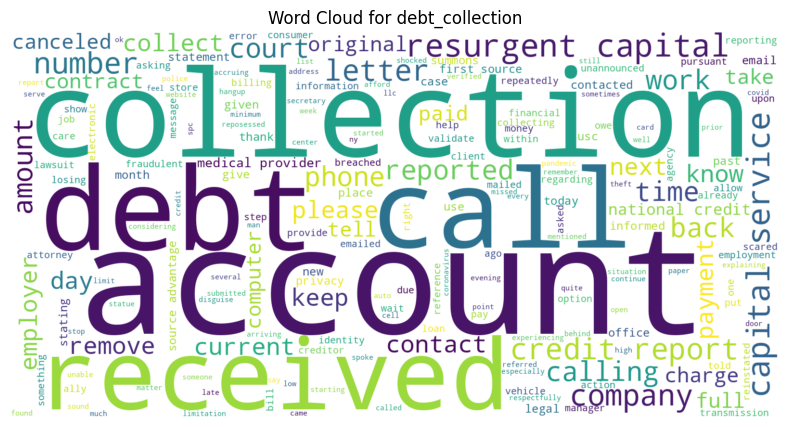

In [27]:
# Plot a word cloud for the second unique product label in the DataFrame
plot_wordcloud(df=df, label_name=df['product'].unique()[1])

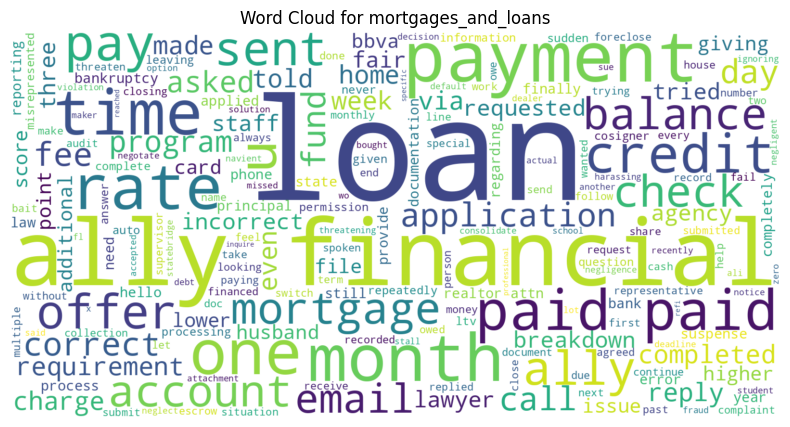

In [28]:
# Plot a word cloud for the third unique product label in the DataFrame
plot_wordcloud(df=df, label_name=df['product'].unique()[2])

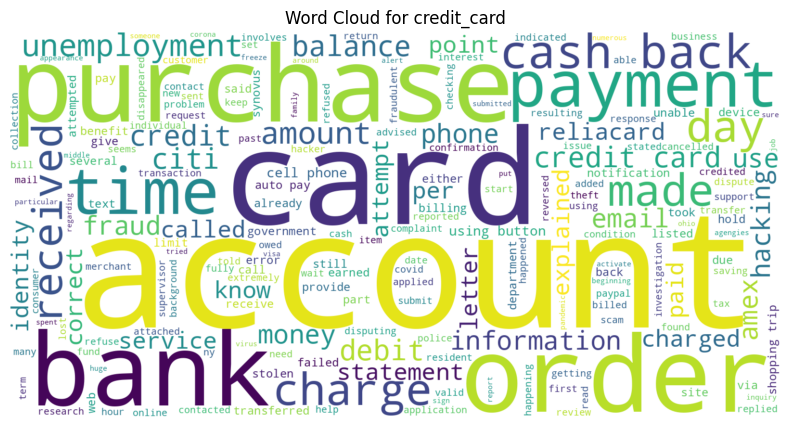

In [29]:
# Plot a word cloud for the fourth unique product label in the DataFrame
plot_wordcloud(df=df, label_name=df['product'].unique()[3])

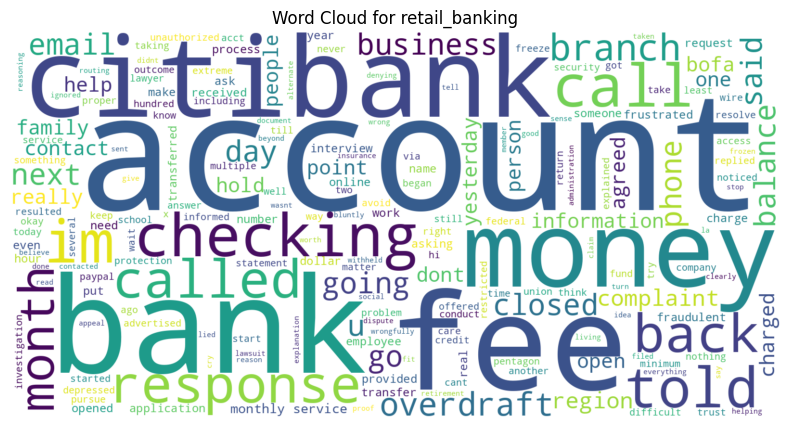

In [30]:
# Plot a word cloud for the fifth unique product label in the DataFrame
plot_wordcloud(df=df, label_name=df['product'].unique()[4])

In [31]:
# Compute the number of words in the 'text_pre_processed' column
df['num_words'] = df['text_pre_processed'].apply(lambda x: len(x.split()))
df.head()

,product,narrative,length,text_pre_processed,length_text_pre_processed,num_words
0,credit_reporting,pmab llc saying owe medical hospital bill paid...,127,pmab llc say owe medical hospital bill pay gra...,116,19
1,credit_reporting,contacted experian correct information report ...,874,contact experian correct information report di...,779,116
2,credit_reporting,experian reporting day late partial account nu...,713,experian reporting day late partial account nu...,616,83
3,credit_reporting,name address account wrong request processed o...,1000,address account wrong request process online m...,936,116
4,credit_reporting,several unrecognizable credit inquires credit ...,180,unrecognizable credit inquire credit profile o...,165,21


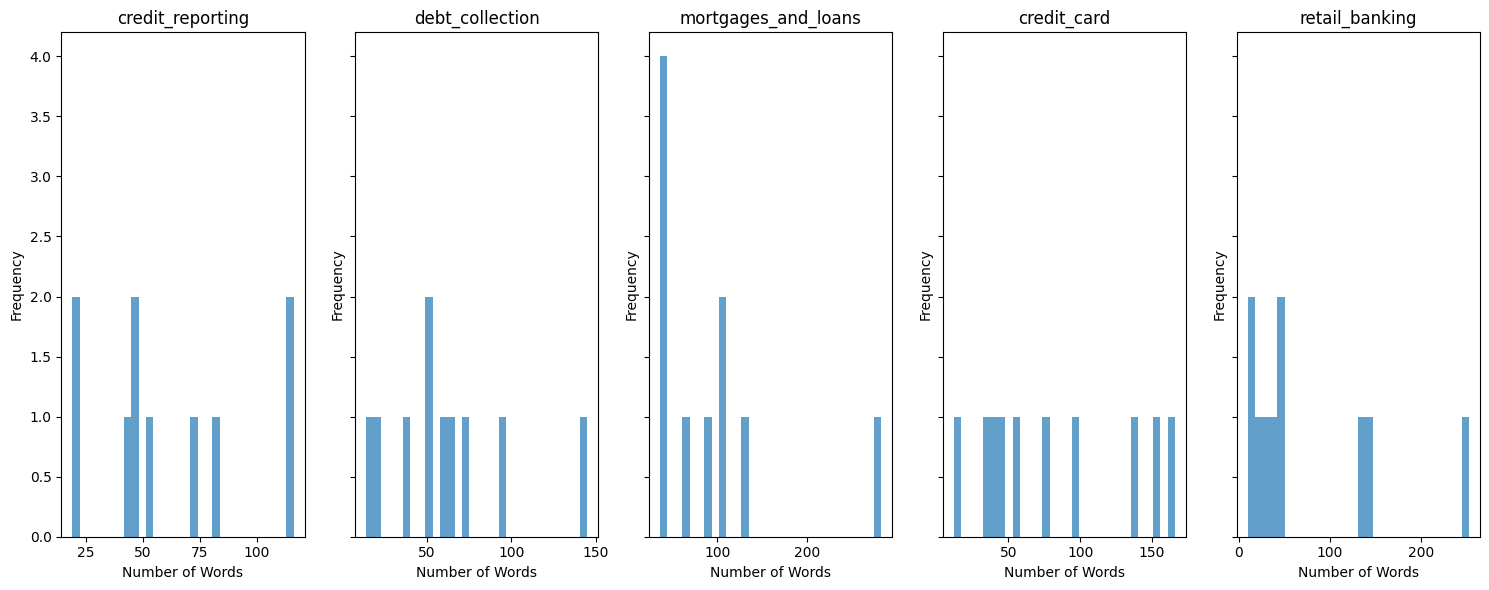

In [32]:
# Set up the plotting area with a single row of subplots
unique_labels = df['product'].unique()
num_labels = len(unique_labels)
fig, axes = plt.subplots(nrows=1, ncols=num_labels, figsize=(15, 6), sharey=True)

# Plot each histogram
for i, label in enumerate(unique_labels):
    axes[i].hist(
        df[df['product'] == label]['num_words'],
        bins=30,
        alpha=0.7
    )
    axes[i].set_title(label)
    axes[i].set_xlabel('Number of Words')
    axes[i].set_ylabel('Frequency')

# Adjust layout
plt.tight_layout()
plt.show()

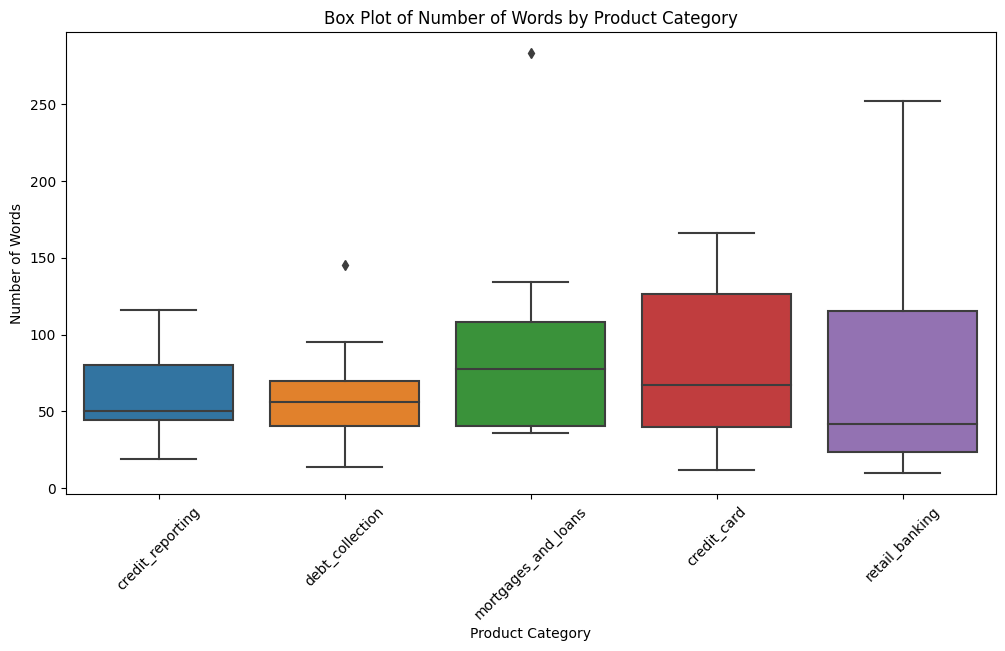

In [33]:
# Plot box plot
plt.figure(figsize=(12, 6))
sns.boxplot(x='product', y='num_words', data=df)
plt.xlabel('Product Category')
plt.ylabel('Number of Words')
plt.title('Box Plot of Number of Words by Product Category')
plt.xticks(rotation=45)
plt.show()

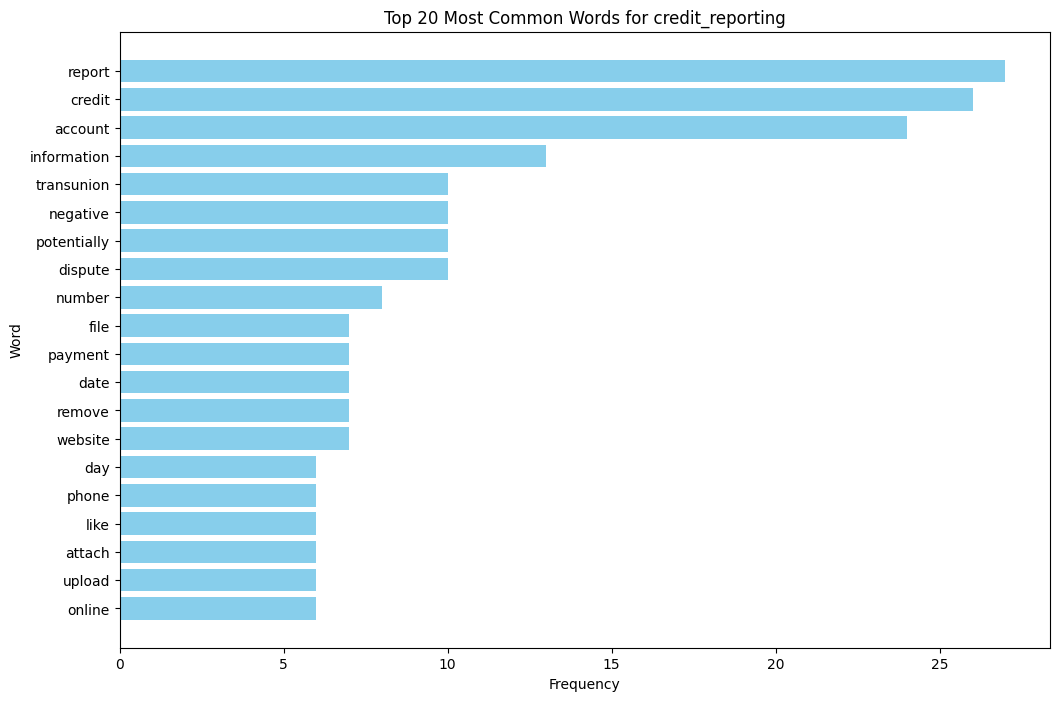

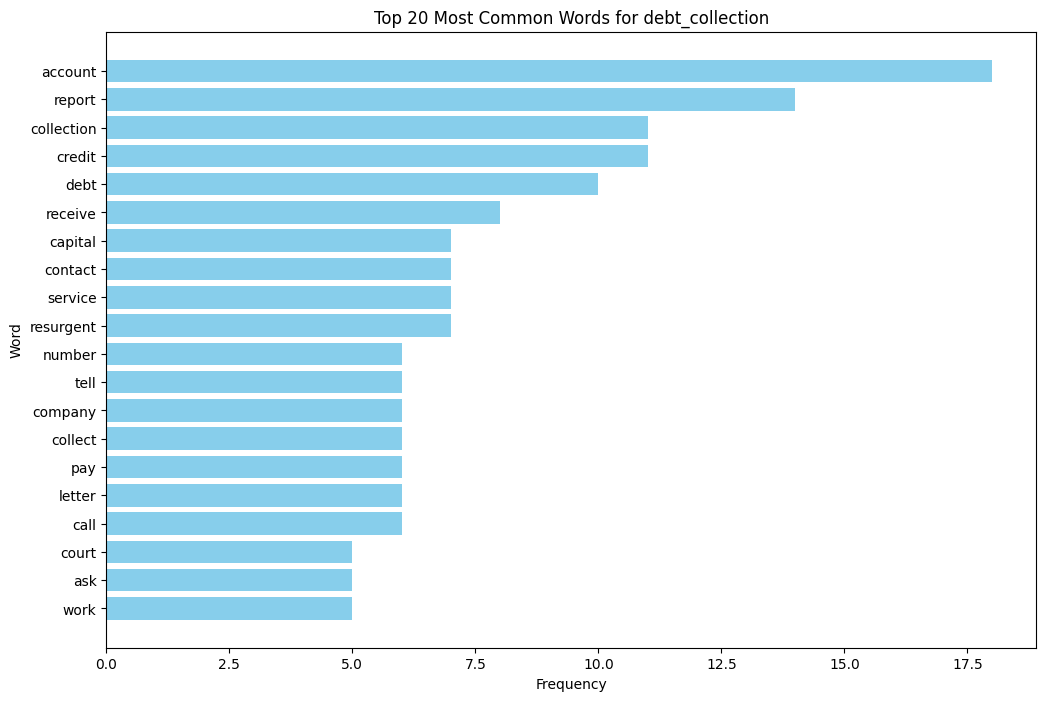

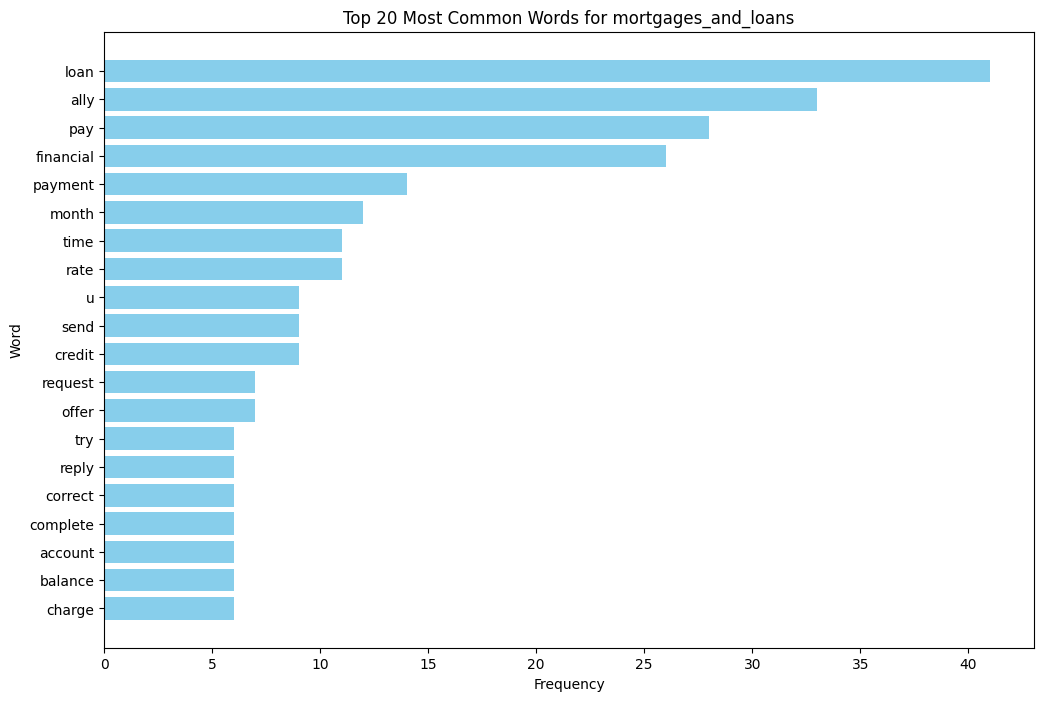

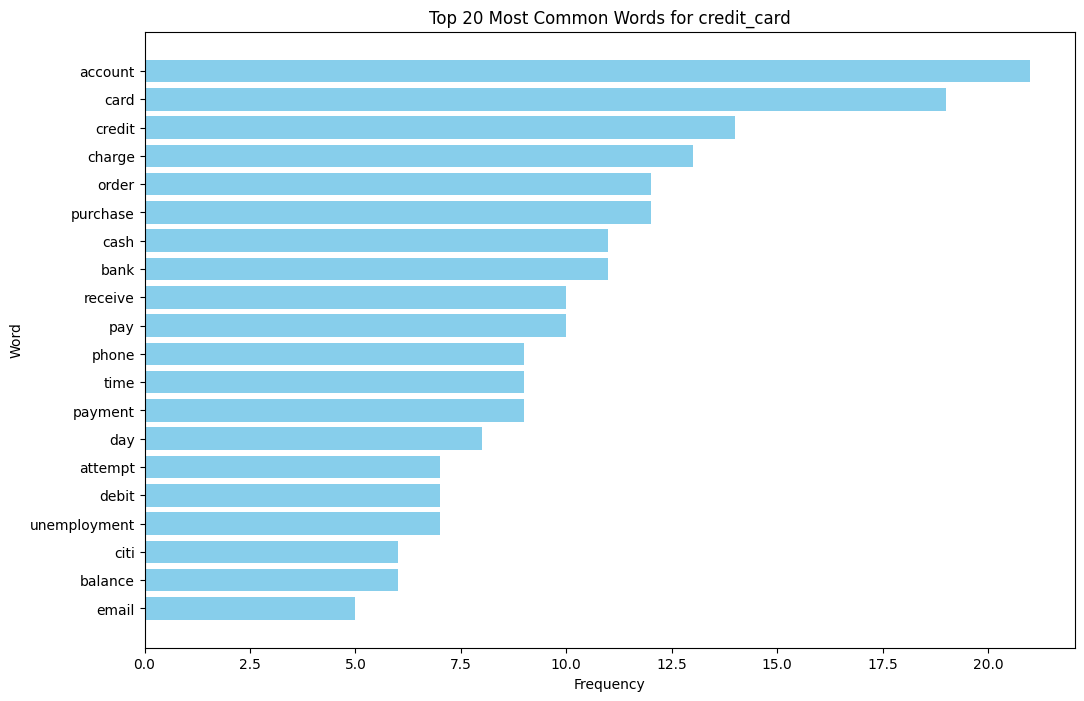

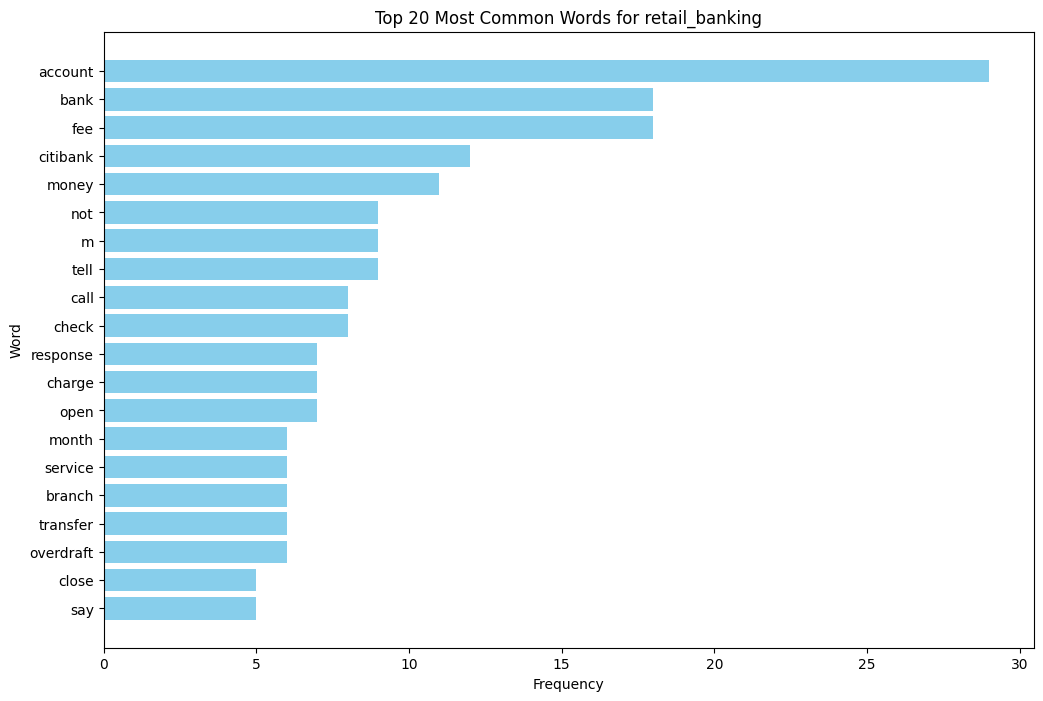

In [34]:
from collections import Counter

# Define a function to plot the top N most common words for a specific product category
def plot_top_words_for_category(df, category):
    # Filter the DataFrame for the given category
    category_texts = df[df['product'] == category]['text_pre_processed']

    # Combine all text for the category into a single string
    combined_text = " ".join(category_texts)

    # Tokenize the combined text
    words = combined_text.split()

    # Compute word frequencies
    word_freq = Counter(words)

    # Convert the word frequencies to a DataFrame
    word_freq_df = pd.DataFrame(word_freq.items(), columns=['Word', 'Frequency'])
    word_freq_df = word_freq_df.sort_values(by='Frequency', ascending=False)

    # Select the top N words
    N = 20  # You can change this value to display more or fewer words
    top_words = word_freq_df.head(N)

    # Plot the bar plot
    plt.figure(figsize=(12, 8))
    plt.barh(top_words['Word'], top_words['Frequency'], color='skyblue')
    plt.xlabel('Frequency')
    plt.ylabel('Word')
    plt.title(f'Top {N} Most Common Words for {category}')
    plt.gca().invert_yaxis()  # To display the highest frequency at the top
    plt.show()

# Get unique product categories
unique_categories = df['product'].unique()

# Plot top words for each product category
for category in unique_categories:
    plot_top_words_for_category(df, category)

In [35]:
# Initialize the LabelEncoder
le = LabelEncoder()

# Encode the 'product' column into numeric labels and assign it to a new column 'target'
df['target'] = le.fit_transform(df['product'])

# Display the first few rows to verify the target encoding
df.head()

,product,narrative,length,text_pre_processed,length_text_pre_processed,num_words,target
0,credit_reporting,pmab llc saying owe medical hospital bill paid...,127,pmab llc say owe medical hospital bill pay gra...,116,19,1
1,credit_reporting,contacted experian correct information report ...,874,contact experian correct information report di...,779,116,1
2,credit_reporting,experian reporting day late partial account nu...,713,experian reporting day late partial account nu...,616,83,1
3,credit_reporting,name address account wrong request processed o...,1000,address account wrong request process online m...,936,116,1
4,credit_reporting,several unrecognizable credit inquires credit ...,180,unrecognizable credit inquire credit profile o...,165,21,1


In [36]:
# Print the class labels in their original form
print(le.classes_)

# Create a mapping between the original product labels and their encoded numeric values
label_mapping = dict(zip(le.classes_, le.transform(le.classes_)))

# Print the mapping of product categories to numeric targets
for product, target in label_mapping.items():
    print(f"Product: {product}, Target: {target}")

['credit_card' 'credit_reporting' 'debt_collection' 'mortgages_and_loans'
 'retail_banking']
Product: credit_card, Target: 0
Product: credit_reporting, Target: 1
Product: debt_collection, Target: 2
Product: mortgages_and_loans, Target: 3
Product: retail_banking, Target: 4


In [37]:
# Features (text data) and target variable
X = df['text_pre_processed']
y = df['target']

# Split the dataset into training and testing sets with stratification to maintain class balance
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=rand_state, stratify=y)

# Print the shapes of the resulting splits
print(f"X_train shape: {X_train.shape}, X_test shape: {X_test.shape}")
print(f"y_train shape: {y_train.shape}, y_test shape: {y_test.shape}")

X_train shape: (40,), X_test shape: (10,)
y_train shape: (40,), y_test shape: (10,)


In [38]:
# Display the counts of each class in the training set, sorted by class index
print("Training set class distribution:")
print(y_train.value_counts().sort_index())

# Display the counts of each class in the testing set, sorted by class index
print("\nTesting set class distribution:")
print(y_test.value_counts().sort_index())

Training set class distribution:
target
0    8
1    8
2    8
3    8
4    8
Name: count, dtype: int64

Testing set class distribution:
target
0    2
1    2
2    2
3    2
4    2
Name: count, dtype: int64


### Bag of Words Representation with n-grams = (1, 1)

In this step, the Bag of Words (BoW) model is applied with unigrams (n-grams = 1). The text data is converted into a numeric representation using `CountVectorizer`, which creates a sparse matrix where each column represents a unique word from the vocabulary, and each row corresponds to a document. The values represent the frequency of word occurrences within each document.

After applying `CountVectorizer`, the resulting matrices are scaled using `MinMaxScaler`. This scaling ensures that all feature values are within a fixed range, which is important for many machine learning models. Specifically, the features are scaled between 0 and 1.

Steps involved:
1. **Convert text to numeric**: `CountVectorizer` is used to transform the training and testing text data into numeric features.
2. **Scale features**: The transformed Bag of Words features are scaled to a range of [0, 1] using `MinMaxScaler`.


In [39]:
# Initialize CountVectorizer for converting text to a numeric representation using Bag of Words
vectorizer = CountVectorizer()

# Initialize MinMaxScaler for scaling feature values
scaler = MinMaxScaler()

# Fit and transform the training data with CountVectorizer
X_train_count_vect = vectorizer.fit_transform(X_train)

# Transform the test data with the same CountVectorizer
X_test_count_vect = vectorizer.transform(X_test)

# Convert sparse matrices to dense arrays and scale the features for training data
X_train_count_vect_scaled = scaler.fit_transform(X_train_count_vect.toarray())

# Scale the features for test data using the same scaler
X_test_count_vect_scaled = scaler.transform(X_test_count_vect.toarray())

# Print the shapes of the resulting feature matrices
print("Training data (count vectorized) shape:", X_train_count_vect.shape)
print("Test data (count vectorized) shape:", X_test_count_vect.shape)
print("Training data (scaled) shape:", X_train_count_vect_scaled.shape)
print("Test data (scaled) shape:", X_test_count_vect_scaled.shape)

Training data (count vectorized) shape: (40, 930)
Test data (count vectorized) shape: (10, 930)
Training data (scaled) shape: (40, 930)
Test data (scaled) shape: (10, 930)


### Bag of Words Representation with n-grams = (1, 3)

In this step, the Bag of Words (BoW) model is applied with n-grams ranging from 1 to 3. This means that the text data is converted into numeric features where each feature represents either a single word, a bigram (two consecutive words), or a trigram (three consecutive words).

The `CountVectorizer` is used to create these features, and `MinMaxScaler` is then applied to scale these features to a range between 0 and 1.

Steps involved:
1. **Convert text to numeric with n-grams**: `CountVectorizer` with `ngram_range=(1, 3)` is used to capture unigrams, bigrams, and trigrams.
2. **Scale features**: The resulting feature matrices are scaled using `MinMaxScaler`.

In [40]:
vectorizer_n_gram = CountVectorizer(analyzer='word', ngram_range=(1, 3))
scaler_n_gram = MinMaxScaler()

# Initialize CountVectorizer to convert text to numeric representation with n-grams (1 to 3)
# Limiting the vocabulary size to 5000 most frequent words to reduce computational load
vectorizer_n_gram = CountVectorizer(ngram_range=(1, 3), max_features=5000)

# Initialize MinMaxScaler for scaling feature values
scaler_n_gram = MinMaxScaler()

# Fit and transform the training data with CountVectorizer (with n-grams)
X_train_count_vect_n_gram = vectorizer_n_gram.fit_transform(X_train)

# Transform the test data with the same CountVectorizer (with n-grams)
X_test_count_vect_n_gram = vectorizer_n_gram.transform(X_test)

# Convert sparse matrices to dense arrays and scale the features for training data
X_train_count_vect_n_gram_scaled = scaler_n_gram.fit_transform(X_train_count_vect_n_gram.toarray())

# Scale the features for test data using the same scaler
X_test_count_vect_n_gram_scaled = scaler_n_gram.transform(X_test_count_vect_n_gram.toarray())

# Print the shapes of the resulting feature matrices
print("Training data (count vectorized with n-grams) shape:", X_train_count_vect_n_gram.shape)
print("Test data (count vectorized with n-grams) shape:", X_test_count_vect_n_gram.shape)
print("Training data (scaled) shape:", X_train_count_vect_n_gram_scaled.shape)
print("Test data (scaled) shape:", X_test_count_vect_n_gram_scaled.shape)

Training data (count vectorized with n-grams) shape: (40, 5000)
Test data (count vectorized with n-grams) shape: (10, 5000)
Training data (scaled) shape: (40, 5000)
Test data (scaled) shape: (10, 5000)


### TF-IDF Vectorization

TF-IDF (Term Frequency-Inverse Document Frequency) is a numerical representation of text data that reflects the importance of words in a document relative to the entire corpus. It adjusts for the frequency of words across all documents, highlighting terms that are important to specific documents while diminishing the weight of frequently occurring terms that are less informative.

**Steps in TF-IDF Vectorization:**
1. **TF-IDF Vectorization**: Converts text data into a matrix of TF-IDF features. Each feature represents the importance of a word in a document, considering both its frequency in the document and its inverse frequency across the corpus.
2. **Scaling**: The resulting TF-IDF matrix is scaled to normalize the feature values. This ensures that all features contribute equally to the model training.

In [41]:
# Initialize TfidfVectorizer for converting text to numeric representation
# Limiting the vocabulary size to 5000 most frequent words to reduce computational load
vectorizer_tfidf = TfidfVectorizer(max_features=5000)

# Initialize MinMaxScaler for scaling feature values
scaler_tfidf = MinMaxScaler()

# Fit and transform the training data with TfidfVectorizer
# This step creates a feature matrix with a capped vocabulary size
X_train_tfidf = vectorizer_tfidf.fit_transform(X_train)

# Transform the test data with the same TfidfVectorizer
# The same vocabulary is used for transforming the test data
X_test_tfidf = vectorizer_tfidf.transform(X_test)

# Convert sparse matrices to dense arrays and scale the features for training data
X_train_tfidf_scaled = scaler_tfidf.fit_transform(X_train_tfidf.toarray())

# Scale the features for test data using the same scaler
X_test_tfidf_scaled = scaler_tfidf.transform(X_test_tfidf.toarray())

# Print the shapes of the resulting feature matrices
print("Training data (TF-IDF vectorized) shape:", X_train_tfidf.shape)
print("Test data (TF-IDF vectorized) shape:", X_test_tfidf.shape)
print("Training data (scaled) shape:", X_train_tfidf_scaled.shape)
print("Test data (scaled) shape:", X_test_tfidf_scaled.shape)


Training data (TF-IDF vectorized) shape: (40, 930)
Test data (TF-IDF vectorized) shape: (10, 930)
Training data (scaled) shape: (40, 930)
Test data (scaled) shape: (10, 930)


### SpaCy Word2Vec

SpaCy's Word2Vec model provides word embeddings, which are dense vector representations of words that capture their semantic meaning. SpaCy's pre-trained word embeddings can be used to convert text data into numerical format, where each document is represented by the average of word vectors for the words in the document.

**Steps for using SpaCy Word2Vec:**
1. **Out-of-Vocabulary (OOV) Check**: Verify how many words in the dataset are out-of-vocabulary (i.e., words not present in the SpaCy model's vocabulary).
2. **Word2Vec Vectorization**: Convert each document into a vector representation by averaging the word vectors of the words in the document.
3. **Scaling**: Normalize the feature values of the vector representations to a range between 0 and 1.

In [42]:
# Create a DataFrame from the training data with text data
df_oov_check = X_train.to_frame(name='text')

# Count the number of words in each text
df_oov_check['num_of_words'] = df_oov_check['text'].apply(lambda x: len([token for token in nlp(x)]))

# Count the number of out-of-vocabulary (OOV) words in each text
df_oov_check['num_of_oov_words'] = df_oov_check['text'].apply(lambda x: len([1 for token in nlp(x) if token.is_oov]))

# Display a sample of the DataFrame to inspect the OOV and word counts
df_oov_check.sample(5)

,text,num_of_words,num_of_oov_words
32,comenity close zale account base fictional cla...,35,2
37,apply fortiva credit card receive credit line ...,151,1
12,receive court summon today debt feel owe summo...,53,0
0,pmab llc say owe medical hospital bill pay gra...,19,1
19,company notify attempt collect debt write comp...,14,0


In [43]:
# Display the distribution of out-of-vocabulary (OOV) words counts
df_oov_check['num_of_oov_words'].value_counts()

num_of_oov_words
0    20
1    13
2     3
3     2
5     1
4     1
Name: count, dtype: int64

In [44]:
# Generate Word2Vec embeddings for the training data
X_train_word2vec_spacy = X_train.apply(lambda x: nlp(x).vector)

# Generate Word2Vec embeddings for the test data
X_test_word2vec_spacy = X_test.apply(lambda x: nlp(x).vector)

# Print the shapes of the embeddings before stacking
print("Before Stacking:")
print("Training data shape:", X_train_word2vec_spacy.shape)
print("Test data shape:", X_test_word2vec_spacy.shape)

# Stack the embeddings into NumPy arrays
X_train_word2vec_spacy = np.stack(X_train_word2vec_spacy)
X_test_word2vec_spacy = np.stack(X_test_word2vec_spacy)

# Print the shapes of the embeddings after stacking
print("After Stacking:")
print("Training data shape:", X_train_word2vec_spacy.shape)
print("Test data shape:", X_test_word2vec_spacy.shape)

# Initialize the MinMaxScaler
scaler_word2vec_spacy = MinMaxScaler()

# Scale the training data
X_train_word2vec_spacy_scaled = scaler_word2vec_spacy.fit_transform(X_train_word2vec_spacy)

# Scale the test data
X_test_word2vec_spacy_scaled = scaler_word2vec_spacy.transform(X_test_word2vec_spacy)

# Print the shapes of the scaled embeddings
print("After Scaling:")
print("Training data shape:", X_train_word2vec_spacy_scaled.shape)
print("Test data shape:", X_test_word2vec_spacy_scaled.shape)

Before Stacking:
Training data shape: (40,)
Test data shape: (10,)
After Stacking:
Training data shape: (40, 300)
Test data shape: (10, 300)
After Scaling:
Training data shape: (40, 300)
Test data shape: (10, 300)


### Gensim Word2Vec

Gensim's Word2Vec is a popular model for generating word embeddings. It uses the Word2Vec algorithm to convert words into dense vector representations based on their context in a corpus. Unlike SpaCy's pre-trained embeddings, Gensim allows for the training of custom embeddings on specific datasets.

**Key Features:**
- **Training Custom Embeddings:** Train embeddings on your own corpus to capture domain-specific nuances.
- **Word Similarity:** Provides functionality to find similarities between words using the trained embeddings.
- **Vector Representations:** Converts words into continuous vector spaces, capturing semantic meanings.

The following code demonstrates how to use Gensim's Word2Vec to transform text data into numerical features.


In [45]:
# Importing the gensim library for downloading pre-trained models
import gensim.downloader as api

# List available pre-trained word vectors models
print("Available models:")
print(list(api.info()['models'].keys()))

# Load the pre-trained Word2Vec model
# Load the GloVe model (e.g., 100-dimensional vectors)
gensim_glove_wv = api.load("glove-wiki-gigaword-100")

# Verify the model is loaded
print("Model loaded successfully.")

Available models:
['fasttext-wiki-news-subwords-300', 'conceptnet-numberbatch-17-06-300', 'word2vec-ruscorpora-300', 'word2vec-google-news-300', 'glove-wiki-gigaword-50', 'glove-wiki-gigaword-100', 'glove-wiki-gigaword-200', 'glove-wiki-gigaword-300', 'glove-twitter-25', 'glove-twitter-50', 'glove-twitter-100', 'glove-twitter-200', '__testing_word2vec-matrix-synopsis']
[==================================================] 100.0% 128.1/128.1MB downloaded
Model loaded successfully.


In [46]:
def pre_process_text_gensim_glove_wv(text):
    """
    Preprocesses the input text to obtain the average Word2Vec vector representation.

    Parameters:
    text (str): The input text to be processed.

    Returns:
    numpy.ndarray: The average vector representation of the text.
                   Returns a zero vector if no words are found in the model.
    """
    # Split the text into tokens (words)
    tokens = text.split()

    # Retrieve vectors for words present in the Word2Vec model
    vectors = [gensim_glove_wv[word] for word in tokens if word in gensim_glove_wv]

    # Calculate the average vector for the words in the text
    if vectors:
        return np.mean(vectors, axis=0)
    else:
        # Return a zero vector if none of the words are in the model
        return np.zeros(300)

In [47]:
# Apply pre-processing to convert text into word2vec vectors using Gensim
X_train_word2vec_gensim = X_train.apply(pre_process_text_gensim_glove_wv)
X_test_word2vec_gensim = X_test.apply(pre_process_text_gensim_glove_wv)
# Print shapes to verify the dimensions
print("Before Stacking:")
print("Training data (Word2Vec Gensim) shape:", X_train_word2vec_gensim.shape)
print("Test data (Word2Vec Gensim) shape:", X_test_word2vec_gensim.shape)


# Convert the lists of word2vec vectors to NumPy arrays
X_train_word2vec_gensim = np.stack(X_train_word2vec_gensim)
X_test_word2vec_gensim = np.stack(X_test_word2vec_gensim)

# Print shapes to verify the dimensions
print("After Stacking:")
print("Training data (Word2Vec Gensim) shape:", X_train_word2vec_gensim.shape)
print("Test data (Word2Vec Gensim) shape:", X_test_word2vec_gensim.shape)

# Initialize MinMaxScaler to scale the features
scaler_word2vec_gensim = MinMaxScaler()

# Scale the word2vec features for both training and test datasets
X_train_word2vec_gensim_scaled = scaler_word2vec_gensim.fit_transform(X_train_word2vec_gensim)
X_test_word2vec_gensim_scaled = scaler_word2vec_gensim.transform(X_test_word2vec_gensim)

# Print shapes of scaled data to verify the dimensions
print("After Scaling:")
print("Scaled training data (Word2Vec Gensim) shape:", X_train_word2vec_gensim_scaled.shape)
print("Scaled test data (Word2Vec Gensim) shape:", X_test_word2vec_gensim_scaled.shape)


Before Stacking:
Training data (Word2Vec Gensim) shape: (40,)
Test data (Word2Vec Gensim) shape: (10,)
After Stacking:
Training data (Word2Vec Gensim) shape: (40, 100)
Test data (Word2Vec Gensim) shape: (10, 100)
After Scaling:
Scaled training data (Word2Vec Gensim) shape: (40, 100)
Scaled test data (Word2Vec Gensim) shape: (10, 100)


### Gensim Doc2Vec Overview

The `Doc2Vec` model from Gensim is a powerful technique for generating fixed-length vector representations for entire documents, rather than individual words. This method is particularly useful for tasks such as document classification, sentiment analysis, and information retrieval.

In the current implementation, the following steps were applied to prepare and train the `Doc2Vec` model:

1. **Data Preparation**:
   - The text data was preprocessed (lowercased, tokenized, lemmatized, etc.) and converted into Gensim's `TaggedDocument` format. Each document is represented by a list of tokens (`words`) and a unique identifier (`tags`), which is required for `Doc2Vec`.

2. **Model Initialization**:
   - The **Distributed Memory (DM)** variant of `Doc2Vec` (the default setting) was used. This method is similar to the Skip-gram model in Word2Vec and predicts words in a document based on their context and the document itself. The model was initialized with the following key parameters:
     - `vector_size=100`: The dimensionality of the document vectors (each document will be represented by a 100-dimensional vector).
     - `window=5`: The model looks at a context window of 5 words around the current word.
     - `min_count=2`: Words with fewer than 2 occurrences are ignored to reduce noise.
     - `epochs=20`: The model iterates over the entire dataset 20 times to learn the document representations.

3. **Training**:
   - After building the vocabulary based on the training data, the `Doc2Vec` model was trained using the training dataset. This allows the model to learn meaningful document vectors by considering both the word context and document identity.

4. **Inferencing**:
   - Once the model was trained, fixed-length vectors for each document in both the training and test datasets were inferred. These vectors capture the semantic structure of the documents and are suitable for downstream machine learning models.

5. **Scaling**:
   - A `MinMaxScaler` was used to scale the document vectors between 0 and 1, ensuring that the features are on a consistent scale for machine learning models.

By applying `Doc2Vec`, textual data was transformed into numeric representations that preserve the semantic content of entire documents, facilitating easier processing for machine learning algorithms.

In [48]:
import gensim
from gensim.models.doc2vec import TaggedDocument

# Prepare TaggedDocument format for training data
# TaggedDocument is required for Doc2Vec, it takes words (the document as a list of tokens)
# and tags (a unique identifier for each document).
# row.split() splits the preprocessed text into individual tokens (words).
tagged_train_data = [TaggedDocument(words=row.split(), tags=[str(index)]) for index, row in enumerate(X_train)]
tagged_test_data = [TaggedDocument(words=row.split(), tags=[str(index)]) for index, row in enumerate(X_test)]

# Initialize and build the Doc2Vec model
# vector_size=100 sets the size of the output document vectors (each document will be represented by a 100-dimensional vector).
# window=5 means the model will look at a context of 5 words to the left and right of the current word.
# min_count=2 ignores all words with total frequency lower than 2 (to remove rare/noisy words).
# workers=4 sets the number of CPU cores to use in parallel for training.
# epochs=20 specifies that the model will train over the entire dataset 20 times.
doc2vec_model = gensim.models.Doc2Vec(vector_size=100, window=5, min_count=2, workers=4, epochs=20)

# Build vocabulary from training data
# This step builds the vocabulary (all unique words) based on the training data.
doc2vec_model.build_vocab(tagged_train_data)

# Train the Doc2Vec model on the training data
# total_examples=doc2vec_model.corpus_count specifies the total number of documents in the training data.
# epochs=doc2vec_model.epochs defines the number of training epochs (iterations over the entire dataset).
doc2vec_model.train(tagged_train_data, total_examples=doc2vec_model.corpus_count, epochs=doc2vec_model.epochs)

In [49]:
# Infer vectors for each document in both the training and test datasets
# The infer_vector method generates a fixed-length vector for each document based on the trained model.
X_train_doc2vec_gensim = np.array([doc2vec_model.infer_vector(row.words) for row in tagged_train_data])
X_test_doc2vec_gensim = np.array([doc2vec_model.infer_vector(row.words) for row in tagged_test_data])

# Print shapes to verify the dimensions of the document vectors
print("Training data (Doc2Vec Gensim) shape:", X_train_doc2vec_gensim.shape)
print("Test data (Doc2Vec Gensim) shape:", X_test_doc2vec_gensim.shape)

# Stack the lists of doc2vec vectors into NumPy arrays
# This step ensures that the vectors are in a format suitable for further processing or model input.
X_train_doc2vec_gensim = np.stack(X_train_doc2vec_gensim)
X_test_doc2vec_gensim = np.stack(X_test_doc2vec_gensim)

# Print shapes to verify the dimensions after stacking
print("After Stacking:")
print("Training data (Doc2Vec Gensim) shape:", X_train_doc2vec_gensim.shape)
print("Test data (Doc2Vec Gensim) shape:", X_test_doc2vec_gensim.shape)

# Initialize MinMaxScaler to scale the features
# This will scale the Doc2Vec vectors to a range between 0 and 1, improving performance in machine learning models.
scaler_doc2vec_gensim = MinMaxScaler()

# Scale the Doc2Vec features for both training and test datasets
# fit_transform is used on training data to compute the scaling parameters, and transform applies it to test data.
X_train_doc2vec_gensim_scaled = scaler_doc2vec_gensim.fit_transform(X_train_doc2vec_gensim)
X_test_doc2vec_gensim_scaled = scaler_doc2vec_gensim.transform(X_test_doc2vec_gensim)

# Print shapes to verify the dimensions after scaling
print("After Scaling:")
print("Training data (Doc2Vec Gensim) shape:", X_train_doc2vec_gensim_scaled.shape)
print("Test data (Doc2Vec Gensim) shape:", X_test_doc2vec_gensim_scaled.shape)

Training data (Doc2Vec Gensim) shape: (40, 100)
Test data (Doc2Vec Gensim) shape: (10, 100)
After Stacking:
Training data (Doc2Vec Gensim) shape: (40, 100)
Test data (Doc2Vec Gensim) shape: (10, 100)
After Scaling:
Training data (Doc2Vec Gensim) shape: (40, 100)
Test data (Doc2Vec Gensim) shape: (10, 100)


### FastText Overview

FastText, developed by Facebook’s AI Research (FAIR) lab, is an extension of Word2Vec that improves word vector representations by considering subword information. This technique is particularly useful for handling out-of-vocabulary words and capturing more nuanced word meanings.

In the current implementation, the following steps were applied to use FastText for text representation:

1. **Data Preparation**:
   - The text data was preprocessed (lowercased, tokenized, lemmatized, etc.) to ensure consistency and improve the quality of the embeddings. Each document was transformed into a list of tokens.

2. **Model Initialization**:
   - The **FastText** model was initialized using Gensim with the following key parameters:
     - `vector_size=100`: Defines the dimensionality of the word vectors (each word will be represented by a 100-dimensional vector).
     - `window=5`: Specifies the context window size, meaning the model looks at 5 words to the left and right of the current word for context.
     - `min_count=2`: Ignores words with a frequency lower than 2 to reduce noise and improve model efficiency.
     - `epochs=20`: Sets the number of iterations over the entire dataset for training the model.
     - `sg=1`: Indicates the use of the Skip-gram method. If set to 0, the model uses the CBOW method.

3. **Training**:
   - The FastText model was trained on the preprocessed text data. This training allows the model to learn word vectors that capture semantic similarities between words, including subword information for better handling of rare and out-of-vocabulary words.

4. **Inferencing**:
   - After training, the vectors for each document were obtained by averaging the word vectors of the tokens in the document. This provides a fixed-length representation for each document, which captures the overall semantic meaning.

5. **Scaling**:
   - The document vectors were scaled using `MinMaxScaler` to ensure that all feature values are within a consistent range (0 to 1), facilitating better performance in machine learning models.

By leveraging FastText, text data was transformed into numeric representations that consider both word and subword information, enhancing the quality of the document embeddings for further analysis and model training.


In [50]:
from gensim.models import FastText

# Data Preparation
# Tokenize the preprocessed text for FastText training
X_train_tokens = X_train.apply(lambda x: x.split())
X_test_tokens = X_test.apply(lambda x: x.split())

# Initialize and build FastText model
# vector_size=100: Dimensionality of the word vectors.
# window=5: Size of the context window used to predict the current word.
# min_count=2: Ignores all words with a frequency lower than 2 to reduce noise.
# epochs=20: Number of iterations over the entire dataset for training.
# sg=1: Use Skip-gram approach (set to 0 for CBOW).
fasttext_model = FastText(vector_size=100, window=5, min_count=2, epochs=20, sg=1)

# Build vocabulary from the training data  (using the tokenized training data)
fasttext_model.build_vocab(corpus_iterable=X_train_tokens)

# Train the FastText model
fasttext_model.train(corpus_iterable=X_train_tokens, total_examples=len(X_train_tokens), epochs=fasttext_model.epochs)

# Infer vectors for each document in the training and test datasets
# Average word vectors to obtain document-level representations
def get_document_vector(tokens):
    vectors = [fasttext_model.wv[word] for word in tokens if word in fasttext_model.wv]
    return np.mean(vectors, axis=0) if vectors else np.zeros(fasttext_model.vector_size)

X_train_fasttext = np.array([get_document_vector(tokens) for tokens in X_train_tokens])
X_test_fasttext = np.array([get_document_vector(tokens) for tokens in X_test_tokens])

# Print shapes to verify the dimensions of the document vectors
print("Training data (FastText) shape:", X_train_fasttext.shape)
print("Test data (FastText) shape:", X_test_fasttext.shape)

# Initialize MinMaxScaler to scale the features
scaler_fasttext = MinMaxScaler()

# Scale the FastText features for both training and test datasets
X_train_fasttext_scaled = scaler_fasttext.fit_transform(X_train_fasttext)
X_test_fasttext_scaled = scaler_fasttext.transform(X_test_fasttext)

# Print shapes to verify the dimensions after scaling
print("After Scaling:")
print("Training data (FastText) shape:", X_train_fasttext_scaled.shape)
print("Test data (FastText) shape:", X_test_fasttext_scaled.shape)

Training data (FastText) shape: (40, 100)
Test data (FastText) shape: (10, 100)
After Scaling:
Training data (FastText) shape: (40, 100)
Test data (FastText) shape: (10, 100)


In [51]:
# Split the raw text from the 'narrative' column into training and test sets
# stratify ensures balanced class distribution in training and test sets
X_train_raw_text, X_test_raw_text, y_train, y_test = train_test_split(df['narrative'], df['target'], test_size=0.2, random_state=rand_state, stratify=df['target'])

# Print the size of the training and test datasets
print("Training set size:", len(X_train_raw_text))
print("Test set size:", len(X_test_raw_text))


Training set size: 40
Test set size: 10


In [52]:
from transformers import BertTokenizer, TFBertModel

# Initialize the BERT tokenizer and model
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')
bert_model = TFBertModel.from_pretrained('bert-base-uncased')

# Function to get BERT embeddings for a given text using TensorFlow tensors
def get_bert_embeddings(text):
    # Tokenize the text and prepare input tensors
    inputs = tokenizer(text, return_tensors='tf', max_length=512, padding='max_length', truncation=True)

    # Pass inputs through BERT model to get the hidden states
    outputs = bert_model(inputs)

    # Return the mean of the token embeddings (averaged across all tokens)
    return tf.reduce_mean(outputs.last_hidden_state, axis=1).numpy().squeeze()

# Get BERT embeddings for training and test data
X_train_bert = np.array([get_bert_embeddings(text) for text in X_train_raw_text])
X_test_bert = np.array([get_bert_embeddings(text) for text in X_test_raw_text])

# Print shapes to verify dimensions
print("Training data (BERT embeddings) shape:", X_train_bert.shape)
print("Test data (BERT embeddings) shape:", X_test_bert.shape)

tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

config.json:   0%|          | 0.00/570 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/440M [00:00<?, ?B/s]

Some weights of the PyTorch model were not used when initializing the TF 2.0 model TFBertModel: ['cls.seq_relationship.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.seq_relationship.weight', 'cls.predictions.bias', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.LayerNorm.weight']
- This IS expected if you are initializing TFBertModel from a PyTorch model trained on another task or with another architecture (e.g. initializing a TFBertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFBertModel from a PyTorch model that you expect to be exactly identical (e.g. initializing a TFBertForSequenceClassification model from a BertForSequenceClassification model).
All the weights of TFBertModel were initialized from the PyTorch model.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFBertModel for predictions w

Training data (BERT embeddings) shape: (40, 768)
Test data (BERT embeddings) shape: (10, 768)


In [53]:
# Initialize MinMaxScaler to scale the features between 0 and 1
scaler_bert = MinMaxScaler()

# Scale the BERT embeddings for both training and test datasets
X_train_bert_scaled = scaler_bert.fit_transform(X_train_bert)
X_test_bert_scaled = scaler_bert.transform(X_test_bert)

# Print shapes to verify the dimensions after scaling
print("After Scaling:")
print("Training data (BERT) shape:", X_train_bert_scaled.shape)
print("Test data (BERT) shape:", X_test_bert_scaled.shape)

After Scaling:
Training data (BERT) shape: (40, 768)
Test data (BERT) shape: (10, 768)


In [54]:
def model_trainer(
    classifiers: Dict[str, BaseEstimator],
    X_train: np.ndarray,
    y_train: np.ndarray,
    X_test: np.ndarray,
    y_test: np.ndarray,
    cv_folds: int = 5,
    scoring: str = 'accuracy'
) -> pd.DataFrame:

    """
    Train multiple classifiers with k-fold cross-validation and plot their performance.

    Parameters:
    - classifiers: Dict[str, BaseEstimator]
        Dictionary where keys are classifier names and values are classifier instances.
    - X_train: np.ndarray
        Features training set.
    - y_train: np.ndarray
        Target training set.
    - X_test: np.ndarray
        Features testing set.
    - y_test: np.ndarray
        Target testing set.
    - cv_folds: int, default=5
        Number of cross-validation folds.
    - scoring: str = 'accuracy'
        Metrics for classification

    Returns:
    - pd.DataFrame
        DataFrame containing the cross-validation results for each classifier.
    """

    results = {}
    cv_results = {}

    for name, classifier in classifiers.items():
        print(f"Training {name}...")

        # Perform cross-validation
        start_cv = time()
        cv_scores = cross_val_score(classifier, X_train, y_train, cv=cv_folds, scoring=scoring)
        end_cv = time()

        # Store cross-validation results
        cv_results[name] = cv_scores

        # Train the classifier
        start_fit = time()
        classifier.fit(X_train, y_train)
        end_fit = time()

        # Predict on test and train sets
        start_predict_test = time()
        predictions_test = classifier.predict(X_test)
        end_predict_test = time()

        start_predict_train = time()
        predictions_train = classifier.predict(X_train)
        end_predict_train = time()

        # Calculate accuracies
        train_accuracy = accuracy_score(y_train, predictions_train)
        test_accuracy = accuracy_score(y_test, predictions_test)

        # Store results
        results[name] = {
            'cv_time': end_cv - start_cv,
            'cv_mean': np.mean(cv_scores),
            'cv_std': np.std(cv_scores),
            'fit_time': end_fit - start_fit,
            'predict_time_test': end_predict_test - start_predict_test,
            'train_accuracy': train_accuracy,
            'predict_time_train': end_predict_train - start_predict_train,
            'test_accuracy': test_accuracy
        }

        # Print confusion matrix
        conf_matrix = confusion_matrix(y_test, predictions_test)
#         print(f"Confusion Matrix for {name}:\n{conf_matrix}")
        print(f"Confusion Matrix for {name}:")

        # Plot confusion matrix
        fig, ax = plt.subplots(figsize=(8, 6))
        sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues", ax=ax)
        ax.set_title(f'Confusion Matrix for {name}')
        ax.set_xlabel('Predicted')
        ax.set_ylabel('True')
        plt.show()

    # Convert results to DataFrame
    results_df = pd.DataFrame(results).T
    cv_results_df = pd.DataFrame(cv_results).T

    print(results_df)
    print(cv_results_df)

    # Plot cross-validation scores
    fig, ax = plt.subplots(figsize=(12, 8))
    box = ax.boxplot(cv_results.values(), vert=True, showmeans=True, patch_artist=True,
                     boxprops=dict(facecolor='lightblue', color='blue'),
                     whiskerprops=dict(color='blue'),
                     capprops=dict(color='blue'),
                     medianprops=dict(color='red'),
                     meanprops=dict(marker='o', markeredgecolor='black', markerfacecolor='orange'))

    # Customize x-axis labels and title
    ax.set_xticklabels(cv_results.keys(), rotation=45, ha='right')
    ax.set_title('Cross-Validation Scores by Classifier', fontsize=16)
    ax.set_ylabel('Accuracy', fontsize=14)
    ax.set_xlabel('Classifier', fontsize=14)

    # Add gridlines
    ax.yaxis.grid(True)

    # Customize background color
    fig.patch.set_facecolor('lightgrey')

    plt.show()

    return results_df

In [55]:
# Define classifiers in a dictionary
classifiers = {
    "MultinomialNB": MultinomialNB(),
    "LogisticRegression": LogisticRegression(max_iter=200),
    "DecisionTree": DecisionTreeClassifier(),
    "RandomForest": RandomForestClassifier(),
    "ExtraTrees": ExtraTreesClassifier(),
    "GradientBoosting": GradientBoostingClassifier(),
    "SVC": SVC(),
    "XGBoost": xgb.XGBClassifier(use_label_encoder=False)
}


In [56]:
# Dictionary mapping options to actual dataset variables (not strings)
datasets = {
     1: (X_train_count_vect_scaled, X_test_count_vect_scaled),
     2: (X_train_count_vect_n_gram_scaled, X_test_count_vect_n_gram_scaled),
     3: (X_train_tfidf_scaled, X_test_tfidf_scaled),
     4: (X_train_word2vec_spacy_scaled, X_test_word2vec_spacy_scaled),
     5: (X_train_word2vec_gensim_scaled, X_test_word2vec_gensim_scaled),
     6: (X_train_doc2vec_gensim_scaled, X_test_doc2vec_gensim_scaled),
     7: (X_train_fasttext_scaled, X_test_fasttext_scaled),
     8: (X_train_bert, X_test_bert)
}

In [57]:
print("Select the dataset representation method:")
print("1: Bag of Words")
print("2: Bag of Words with n-grams (1, 3)")
print("3: TF-IDF")
print("4: SpaCy Word2Vec")
print("5: Gensim Word2Vec")
print("6: Gensim Doc2Vec")
print("7: FastText")
print("8: BERT")

#option = input("Enter the option number: ")
option = 4 # using SpaCy Word2vec
# Initialize variables
X_train_user_specified, X_test_user_specified = None, None

# Validate user selection
if option in datasets:
    X_train_user_specified, X_test_user_specified = datasets[option]
else:
    # Set variables to blank if invalid selection
    print("Invalid option selected. Please try again.")
    X_train_user_specified, X_test_user_specified = None, None

Select the dataset representation method:
1: Bag of Words
2: Bag of Words with n-grams (1, 3)
3: TF-IDF
4: SpaCy Word2Vec
5: Gensim Word2Vec
6: Gensim Doc2Vec
7: FastText
8: BERT


Training MultinomialNB...
Confusion Matrix for MultinomialNB:


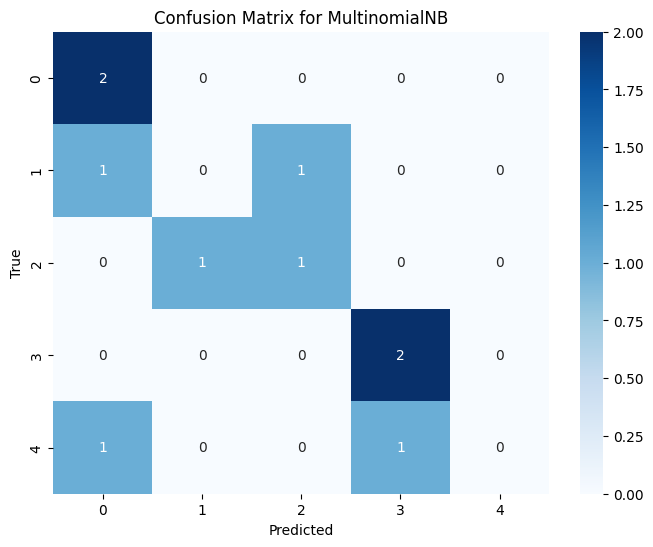

Training LogisticRegression...
Confusion Matrix for LogisticRegression:


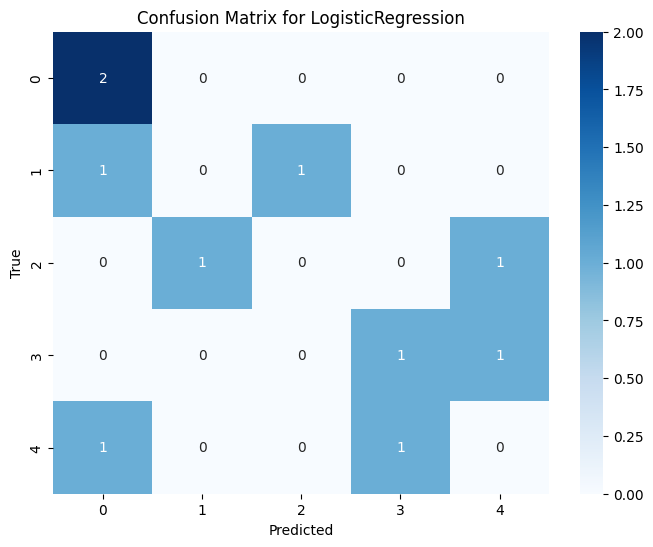

Training DecisionTree...
Confusion Matrix for DecisionTree:


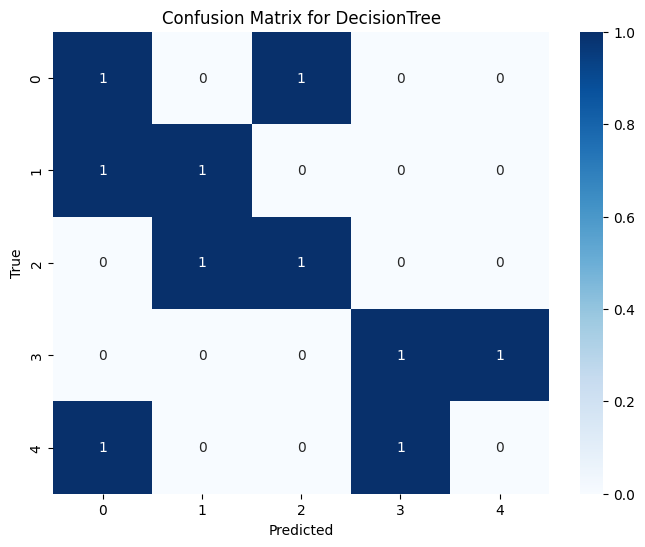

Training RandomForest...
Confusion Matrix for RandomForest:


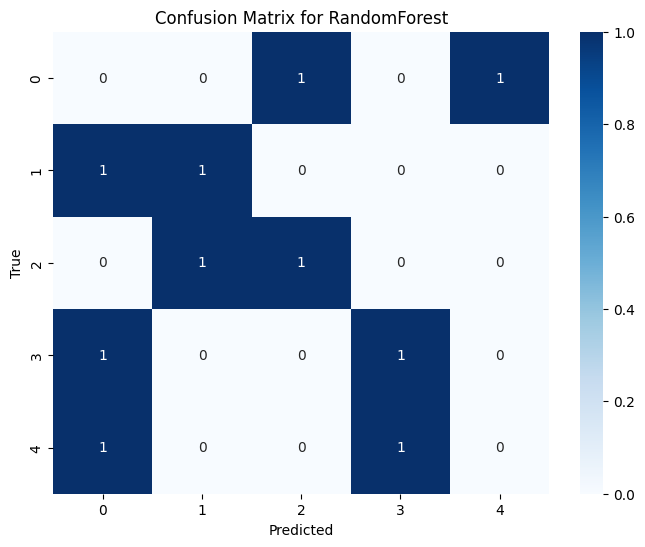

Training ExtraTrees...
Confusion Matrix for ExtraTrees:


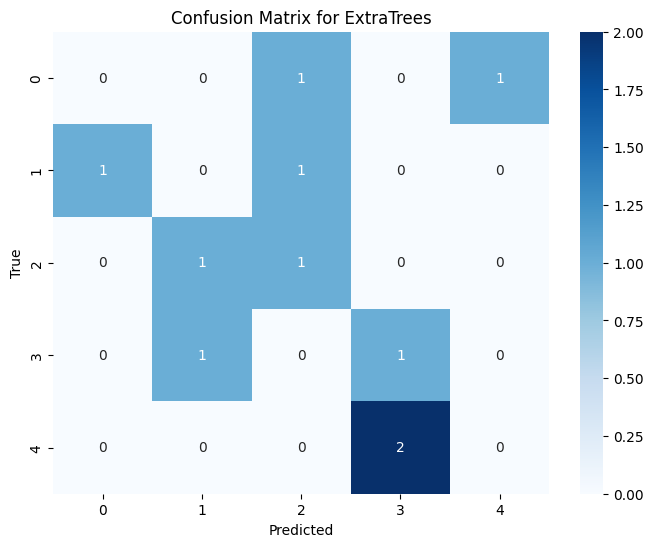

Training GradientBoosting...
Confusion Matrix for GradientBoosting:


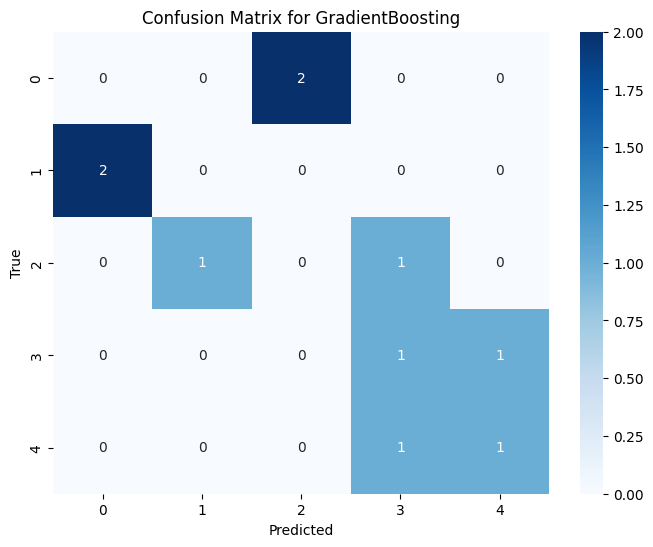

Training SVC...
Confusion Matrix for SVC:


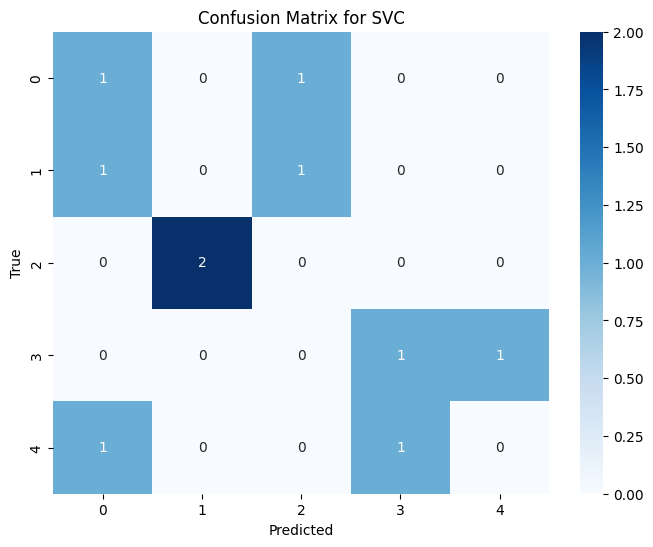

Training XGBoost...
Confusion Matrix for XGBoost:


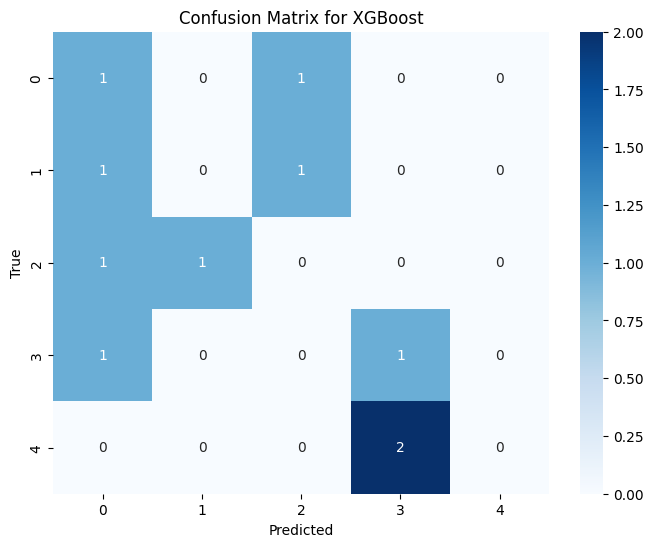

                     cv_time  cv_mean    cv_std  fit_time  predict_time_test  \
MultinomialNB       0.018516    0.400  0.122474  0.001411           0.000139   
LogisticRegression  0.232663    0.450  0.100000  0.044571           0.000251   
DecisionTree        0.034515    0.250  0.158114  0.006316           0.000311   
RandomForest        0.905760    0.400  0.122474  0.176933           0.005672   
ExtraTrees          0.678156    0.300  0.127475  0.128097           0.005555   
GradientBoosting    6.592916    0.325  0.127475  1.750671           0.000767   
SVC                 0.021243    0.200  0.100000  0.001493           0.000309   
XGBoost             0.612344    0.175  0.127475  0.136209           0.001523   

                    train_accuracy  predict_time_train  test_accuracy  
MultinomialNB                0.875            0.000151            0.5  
LogisticRegression           1.000            0.000150            0.3  
DecisionTree                 1.000            0.000187         

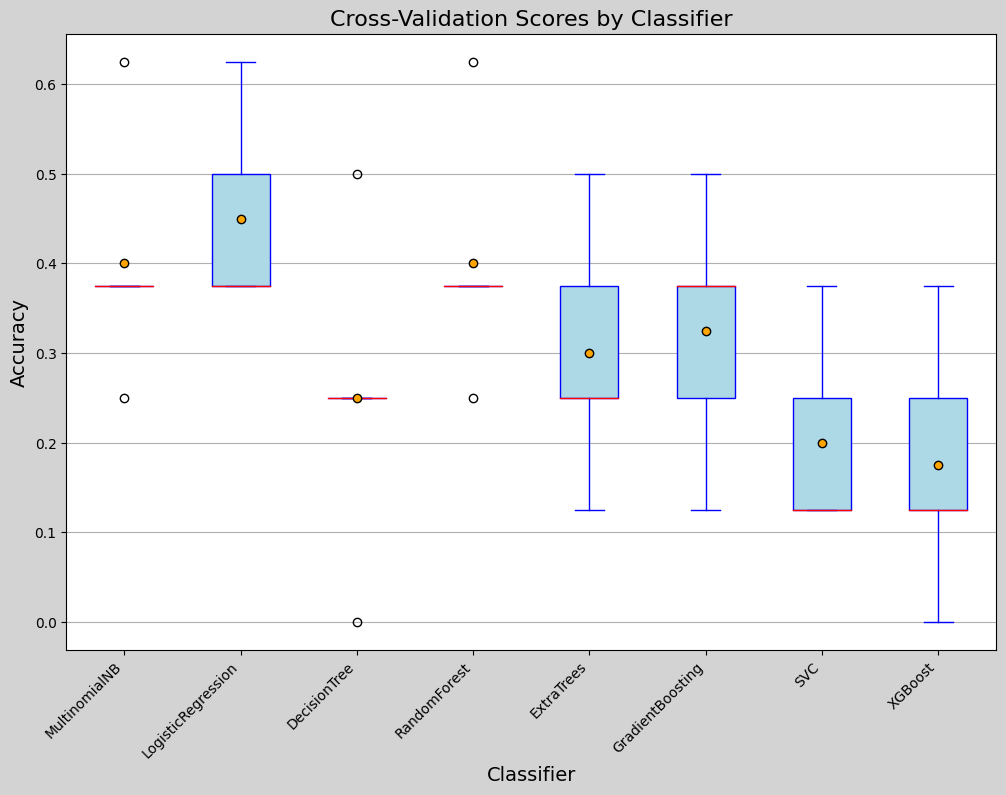

In [58]:
if X_train_user_specified is not None and X_test_user_specified is not None:
    results = model_trainer(
        classifiers,
        X_train_user_specified,
        y_train,
        X_test_user_specified,
        y_test
    )

In [59]:
results

,cv_time,cv_mean,cv_std,fit_time,predict_time_test,train_accuracy,predict_time_train,test_accuracy
MultinomialNB,0.018516,0.400,0.122474,0.001411,0.000139,0.875,0.000151,0.5
LogisticRegression,0.232663,0.450,0.100000,0.044571,0.000251,1.000,0.000150,0.3
DecisionTree,0.034515,0.250,0.158114,0.006316,0.000311,1.000,0.000187,0.4
RandomForest,0.905760,0.400,0.122474,0.176933,0.005672,1.000,0.006052,0.3
ExtraTrees,0.678156,0.300,0.127475,0.128097,0.005555,1.000,0.005970,0.2
GradientBoosting,6.592916,0.325,0.127475,1.750671,0.000767,1.000,0.000897,0.2
SVC,0.021243,0.200,0.100000,0.001493,0.000309,1.000,0.000601,0.2
XGBoost,0.612344,0.175,0.127475,0.136209,0.001523,1.000,0.000708,0.2


In [60]:
# Use the function to train, validate, and evaluate the classifiers
'''
# Train the model using Bag of Words representation and store the results
results_count_vect = model_trainer(X_train_count_vect_scaled, y_train, X_test_count_vect_scaled, y_test)

# Train the model using Bag of Words with n-grams (1, 3) representation and store the results
results_count_vect_n_gram = model_trainer(X_train_count_vect_n_gram_scaled, y_train, X_test_count_vect_n_gram_scaled, y_test)

# Train the model using TF-IDF representation and store the results
results_tfidf = model_trainer(X_train_tfidf_scaled, y_train, X_test_tfidf_scaled, y_test)

# Train the model using SpaCy Word2Vec representation and store the results
results_word2vec_spacy = model_trainer(X_train_word2vec_spacy_scaled, y_train, X_test_word2vec_spacy_scaled, y_test)

# Train the model using Gensim Word2Vec representation and store the results
results_word2vec_gensim = model_trainer(X_train_word2vec_gensim_scaled, y_train, X_test_word2vec_gensim_scaled, y_test)

# Train the model using Gensim Doc2Vec representation and store the results
results_doc2vec_gensim = model_trainer(X_train_doc2vec_gensim_scaled, y_train, X_test_doc2vec_gensim_scaled, y_test)

# Train the model using FastText representation and store the results
results_fasttext = model_trainer(X_train_fasttext_scaled, y_train, X_test_fasttext_scaled, y_test)

# Train the model using BERT representation and store the results
results_bert = model_trainer(X_train_bert, y_train, X_test_bert, y_test)
'''

'\n# Train the model using Bag of Words representation and store the results\nresults_count_vect = model_trainer(X_train_count_vect_scaled, y_train, X_test_count_vect_scaled, y_test)\n\n# Train the model using Bag of Words with n-grams (1, 3) representation and store the results\nresults_count_vect_n_gram = model_trainer(X_train_count_vect_n_gram_scaled, y_train, X_test_count_vect_n_gram_scaled, y_test)\n\n# Train the model using TF-IDF representation and store the results\nresults_tfidf = model_trainer(X_train_tfidf_scaled, y_train, X_test_tfidf_scaled, y_test)\n\n# Train the model using SpaCy Word2Vec representation and store the results\nresults_word2vec_spacy = model_trainer(X_train_word2vec_spacy_scaled, y_train, X_test_word2vec_spacy_scaled, y_test)\n\n# Train the model using Gensim Word2Vec representation and store the results\nresults_word2vec_gensim = model_trainer(X_train_word2vec_gensim_scaled, y_train, X_test_word2vec_gensim_scaled, y_test)\n\n# Train the model using Gensim

In [61]:
# Using Neural networks

In [62]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, Dense, Flatten, Conv1D, MaxPooling1D, LSTM, SimpleRNN, Dropout, Bidirectional
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.preprocessing.text import Tokenizer
from sklearn.model_selection import train_test_split

# Extracting text data and labels from the DataFrame
texts = df['text_pre_processed'].tolist()  # Preprocessed text data
labels = df['target'].tolist()  # Target labels

# Tokenizing the text data
tokenizer = Tokenizer(num_words=5000)  # Initialize tokenizer with a limit on the number of words
tokenizer.fit_on_texts(texts)  # Fit the tokenizer on the preprocessed text data
X_nn = tokenizer.texts_to_sequences(texts)  # Convert text to sequences of integers

# Padding sequences to ensure the same length
max_length = max(len(seq) for seq in X_nn)  # Determine the maximum length of sequences in the data
X_nn = pad_sequences(X_nn, maxlen=max_length)  # Pad sequences to ensure uniform length

# Convert lists to NumPy arrays
X_nn = np.array(X_nn)
labels = np.array(labels)

# Splitting the data into training and testing sets
X_train_nn, X_test_nn, y_train_nn, y_test_nn = train_test_split(X_nn, labels, test_size=0.2, random_state=42, stratify=labels)
# 'stratify=labels' ensures that the class distribution is similar in both training and test sets

# Setting up parameters for the embedding layer
vocab_size = len(tokenizer.word_index) + 1  # Vocabulary size + 1 for the padding token
embedding_dim = 50  # Dimension of the embedding vectors

# Define the number of output neurons based on the number of unique classes in the target variable
num_of_output_neurons = len(df['target'].value_counts())

In [63]:
# Basic ANN Model
def create_ann_model():
    model = Sequential([
        Embedding(input_dim=vocab_size, output_dim=embedding_dim, input_length=max_length),
        Flatten(),
        Dense(64, activation='relu'),
        Dropout(0.5),
        Dense(num_of_output_neurons, activation='softmax')  # Use softmax for multiclass classification
    ])
    model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])
    return model

In [64]:
# CNN Model
def create_cnn_model():
    model = Sequential([
        Embedding(input_dim=vocab_size, output_dim=embedding_dim, input_length=max_length),
        Conv1D(filters=64, kernel_size=5, activation='relu'),
        MaxPooling1D(pool_size=4),
        Flatten(),
        Dense(64, activation='relu'),
        Dropout(0.5),
        Dense(num_of_output_neurons, activation='softmax')  # Use softmax for multiclass classification
    ])
    model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])
    return model

In [65]:
# RNN Model
def create_rnn_model():
    model = Sequential([
        Embedding(input_dim=vocab_size, output_dim=embedding_dim, input_length=max_length),
        SimpleRNN(64, activation='relu'),
        Dense(64, activation='relu'),
        Dropout(0.5),
        Dense(num_of_output_neurons, activation='softmax')  # Use softmax for multiclass classification
    ])
    model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])
    return model

In [66]:
# LSTM Model
def create_lstm_model():
    model = Sequential([
        Embedding(input_dim=vocab_size, output_dim=embedding_dim, input_length=max_length),
        LSTM(64, return_sequences=True),
        LSTM(32),
        Dense(64, activation='relu'),
        Dropout(0.5),
        Dense(num_of_output_neurons, activation='softmax')  # Use softmax for multiclass classification
    ])
    model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])
    return model

In [67]:
# Bidirectional LSTM Model
def create_bidirectional_lstm_model():
    """
    Create and compile a Bidirectional LSTM model for multiclass classification.
    """
    model = Sequential([
        Embedding(input_dim=vocab_size, output_dim=embedding_dim, input_length=max_length),
        Bidirectional(LSTM(64, return_sequences=True)),
        LSTM(32),
        Dense(64, activation='relu'),
        Dropout(0.5),
        Dense(num_of_output_neurons, activation='softmax')  # Change to 5 for multiclass classification
    ])
    model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])
    return model

In [68]:
# Train and evaluate models with a confusion matrix
def train_and_evaluate_model(model_fn):
    model = model_fn()

    # Train the model
    history = model.fit(X_train_nn, y_train_nn, epochs=5, batch_size=32, validation_split=0.2, verbose=1)

    # Evaluate the model on test data
    loss, accuracy = model.evaluate(X_test_nn, y_test_nn, verbose=0)
    print(f"Test Loss: {loss:.4f}, Test Accuracy: {accuracy:.4f}")

    # Make predictions on test data
    y_pred_prob = model.predict(X_test_nn, verbose=0)

    # Convert predicted probabilities to class labels
    y_pred = np.argmax(y_pred_prob, axis=1)

    # Generate confusion matrix
    cm = confusion_matrix(y_test_nn, y_pred)

    # Convert confusion matrix to DataFrame for better visualization
    cm_df = pd.DataFrame(cm, index=[f'Actual_{i}' for i in range(num_of_output_neurons)],
                         columns=[f'Pred_{i}' for i in range(num_of_output_neurons)])

    # Plotting the confusion matrix as a heatmap
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm_df, annot=True, fmt='d', cmap='Blues', linewidths=0.5)
    plt.title('Confusion Matrix')
    plt.ylabel('True Label')
    plt.xlabel('Predicted Label')
    plt.show()

    return model

Training ANN model...
Epoch 1/5
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step - accuracy: 0.0938 - loss: 1.6176 - val_accuracy: 0.2500 - val_loss: 1.6205
Epoch 2/5
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 62ms/step - accuracy: 0.3125 - loss: 1.5931 - val_accuracy: 0.0000e+00 - val_loss: 1.6959
Epoch 3/5
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step - accuracy: 0.2500 - loss: 1.5515 - val_accuracy: 0.1250 - val_loss: 1.7087
Epoch 4/5
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step - accuracy: 0.4062 - loss: 1.5102 - val_accuracy: 0.1250 - val_loss: 1.7123
Epoch 5/5
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step - accuracy: 0.5312 - loss: 1.4557 - val_accuracy: 0.0000e+00 - val_loss: 1.6945
Test Loss: 1.6341, Test Accuracy: 0.1000


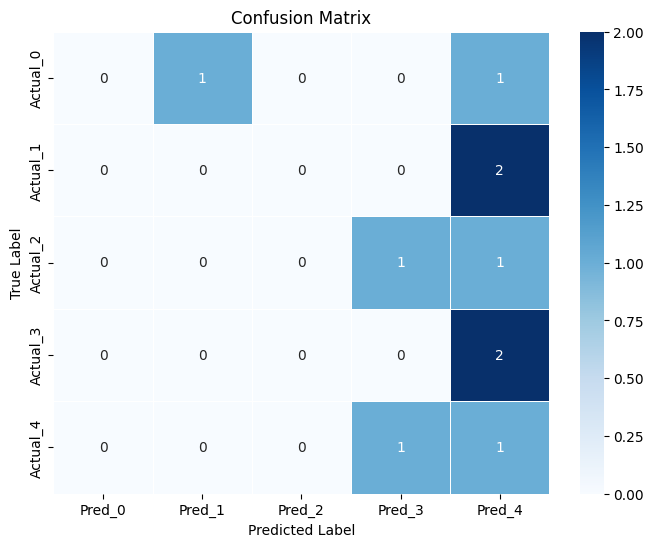

In [69]:
print("Training ANN model...")
ann_model = train_and_evaluate_model(create_ann_model)

In [70]:
# Use the function to train, validate, and evaluate the classifiers
'''
print("Training ANN model...")
ann_model = train_and_evaluate_model(create_ann_model)

print("Training CNN model...")
cnn_model = train_and_evaluate_model(create_cnn_model)

print("Training RNN model...")
rnn_model = train_and_evaluate_model(create_rnn_model)

print("Training LSTM model...")
lstm_model = train_and_evaluate_model(create_lstm_model)

print("Training Bidirectional LSTM model...")
bidirectional_lstm_model = train_and_evaluate_model(create_bidirectional_lstm_model)
'''

'\nprint("Training ANN model...")\nann_model = train_and_evaluate_model(create_ann_model)\n\nprint("Training CNN model...")\ncnn_model = train_and_evaluate_model(create_cnn_model)\n\nprint("Training RNN model...")\nrnn_model = train_and_evaluate_model(create_rnn_model)\n\nprint("Training LSTM model...")\nlstm_model = train_and_evaluate_model(create_lstm_model)\n\nprint("Training Bidirectional LSTM model...")\nbidirectional_lstm_model = train_and_evaluate_model(create_bidirectional_lstm_model)\n'